Resultados guardados en: /Users/alejandra/Documents/GitHub/CranberryLab/Internal_structure/PDF/Stamp_photos/JPG/results.csv
Imagen anotada guardada en: /Users/alejandra/Documents/GitHub/CranberryLab/Internal_structure/PDF/Stamp_photos/JPG/frutos_anotados_con_diametro.png


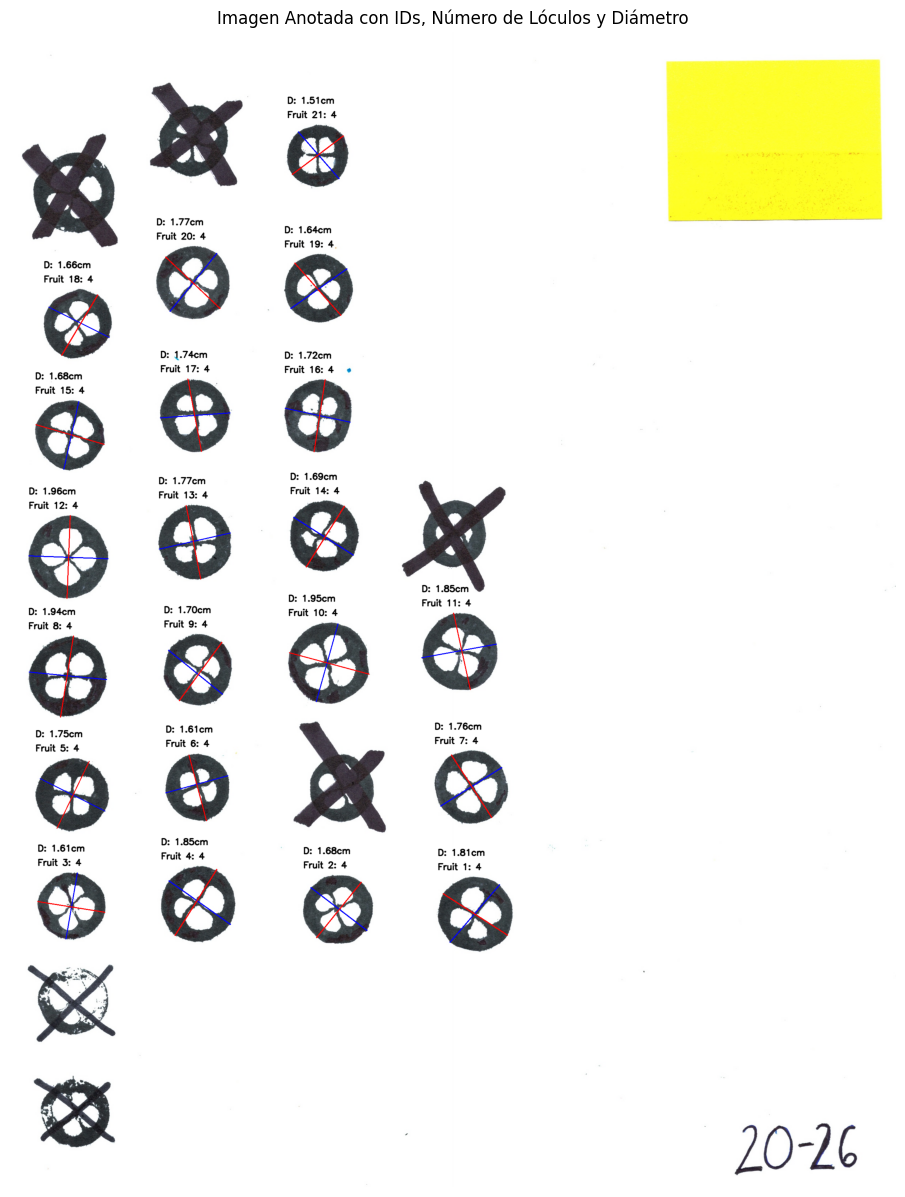

In [7]:
import cv2
import numpy as np
import csv
from matplotlib import pyplot as plt
from scipy.spatial import ConvexHull
import pytesseract

# Leer la imagen
image_path = "/Users/alejandra/Documents/GitHub/CranberryLab/Internal_structure/PDF/Stamp_photos/JPG/pagina_1.jpg"

img = cv2.imread(image_path)

# Detectar texto en la imagen
def extract_sample_id(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convertir a escala de grises
    text = pytesseract.image_to_string(gray_image, lang="eng")  # Extraer texto
    # Filtrar el texto detectado (por ejemplo, eliminar caracteres especiales y espacios adicionales)
    filtered_text = text.strip().split("\n")[0]  # Tomar la primera línea como Sample_ID
    return filtered_text

# Obtener el Sample_ID desde la imagen
sample_id = extract_sample_id(img)

# Detectar el rectángulo amarillo para calcular escala
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
lower_yellow = np.array([20, 100, 100])
upper_yellow = np.array([30, 255, 255])
yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
contours, _ = cv2.findContours(yellow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Encontrar el rectángulo amarillo más grande
largest_area = 0
reference_rect = None
for contour in contours:
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    if len(approx) == 4 and cv2.isContourConvex(approx):
        area = cv2.contourArea(approx)
        if area > largest_area:
            largest_area = area
            reference_rect = cv2.boundingRect(approx)

# Calcular escala en píxeles/cm
if reference_rect:
    _, _, ref_width_px, ref_height_px = reference_rect
    ref_width_cm = 5.1  # Ancho en cm
    ref_height_cm = 3.8  # Alto en cm
    px_per_cm_x = ref_width_px / ref_width_cm
    px_per_cm_y = ref_height_px / ref_height_cm
else:
    raise ValueError("No se detectó el rectángulo amarillo para calcular la escala.")

# Ancho y alto reales de la imagen en cm
image_width_cm = 27.85  # Reemplaza con el ancho real de la imagen en cm
image_height_cm = 21.8  # Reemplaza con el alto real de la imagen en cm

if img is not None:
    image_height_px, image_width_px = img.shape[:2]  # Obtén las dimensiones de la imagen en píxeles
    px_per_cm_x = image_width_px / image_width_cm
    px_per_cm_y = image_height_px / image_height_cm
else:
    raise ValueError("La imagen no está cargada, no se pueden calcular las escalas.")


# Procesar frutos y lóculos
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
closed_binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
contours, hierarchy = cv2.findContours(closed_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

def is_contour_bad(c, min_area=500, min_circularity=0.6, max_circularity=1.2):
    area = cv2.contourArea(c)
    perimeter = cv2.arcLength(c, True)
    if perimeter == 0:
        return True
    circularity = 4 * np.pi * (area / (perimeter * perimeter))
    return area < min_area or not (min_circularity <= circularity <= max_circularity)

filtered_contours = [
    i for i in range(len(contours))
    if hierarchy[0][i][3] == -1 and not is_contour_bad(contours[i])
]

fruit_locus_map = {}
for i in filtered_contours:
    fruit_locus_map[i] = []
    for j in range(len(contours)):
        if hierarchy[0][j][3] == i:
            fruit_locus_map[i].append(j)

min_locus_area = 50
filtered_fruit_locus_map = {
    fruit_idx: [loculus_idx for loculus_idx in loculi if cv2.contourArea(contours[loculus_idx]) > min_locus_area]
    for fruit_idx, loculi in fruit_locus_map.items()
    if len(loculi) > 1
}

# Calcular métricas de lóculos y convertir a cm
results = []
image_with_annotations = img.copy()
sequential_id = 1  # Iniciar el ID secuencial

for fruit_id, loculi in filtered_fruit_locus_map.items():
    n_locules = len(loculi)

    # Calcular el diámetro más largo (convex hull)
    points = contours[fruit_id].reshape(-1, 2)
    hull = ConvexHull(points)
    max_diameter_px = 0
    point1 = None
    point2 = None
    
    # Encontrar los dos puntos extremos que forman el diámetro más largo
    for i in hull.vertices:
        for j in hull.vertices:
            dist = np.linalg.norm(points[i] - points[j])
            if dist > max_diameter_px:
                max_diameter_px = dist
                point1 = points[i]
                point2 = points[j]

    # Convertir el diámetro a centímetros
    max_diameter_cm = max_diameter_px / ((px_per_cm_x + px_per_cm_y) / 2)

    # Calcular el ancho (menor distancia perpendicular al eje mayor)
    #min_diameter_cm = cv2.contourArea(contours[fruit_id]) / max_diameter_cm
    
    # Calcular el eje menor (ancho)
    # Encontrar los dos puntos más alejados en la dirección perpendicular al eje mayor
    line_vector = point2 - point1
    perpendicular_unit_vector = np.array([-line_vector[1], line_vector[0]])  # Perpendicular
    perpendicular_unit_vector = perpendicular_unit_vector / np.linalg.norm(perpendicular_unit_vector)  # Normalizar

    # Inicializar valores para el eje menor
    min_point = None
    max_point = None
    min_projection = float('inf')
    max_projection = float('-inf')

    # Calcular las proyecciones de los puntos sobre la línea perpendicular
    for point in points:
        projection = np.dot(point - point1, perpendicular_unit_vector)
        if projection < min_projection:
            min_projection = projection
            min_point = point
        if projection > max_projection:
            max_projection = projection
            max_point = point

    # Convertir el ancho (distancia entre los extremos) a centímetros
    min_diameter_px = max_projection - min_projection
    min_diameter_cm = min_diameter_px / ((px_per_cm_x + px_per_cm_y) / 2)

    # Dibujar el eje menor (línea azul) en la imagen
    if min_point is not None and max_point is not None:
        cv2.line(
            image_with_annotations,
            tuple(min_point.astype(int)),  # Convertir a enteros para las coordenadas
            tuple(max_point.astype(int)),  # Convertir a enteros para las coordenadas
            (255, 0, 0),  # Color azul en BGR
            2  # Grosor de la línea
        )

    if loculi:
        locule_areas_px = [cv2.contourArea(contours[locule]) for locule in loculi]
        locule_areas_cm = [area / (px_per_cm_x * px_per_cm_y) for area in locule_areas_px]
        locule_mean = np.mean(locule_areas_cm)
        locule_sd = np.std(locule_areas_cm, ddof=1)
        locule_cv = (locule_sd / locule_mean) * 100 if locule_mean != 0 else 0
        locule_total_area = sum(locule_areas_cm)
        pulp_area_cm = (cv2.contourArea(contours[fruit_id]) / (px_per_cm_x * px_per_cm_y))
        locule_pulp_ratio = (locule_total_area / pulp_area_cm) * 100
    else:
        locule_mean = locule_sd = locule_cv = locule_total_area = pulp_area_cm = locule_pulp_ratio = 0

    # Anotar en la imagen
    x, y, _, _ = cv2.boundingRect(contours[fruit_id])
    cv2.putText(
        image_with_annotations,
        f"Fruit {sequential_id}: {n_locules}",
        (x, y - 20),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.8,
        (0, 0, 0),
        2,
        cv2.LINE_AA
    )
    cv2.putText(
        image_with_annotations,
        f"D: {max_diameter_cm:.2f}cm",
        (x, y - 60),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.8,
        (0, 0, 0),
        2,
        cv2.LINE_AA
    )
    
    if point1 is not None and point2 is not None:
        cv2.line(
            image_with_annotations,
            tuple(point1),  # Convertir el primer punto a tupla
            tuple(point2),  # Convertir el segundo punto a tupla
            (0, 0, 255),  # Color rojo en BGR
            2  # Grosor de la línea
        )
    
    # Agregar resultados a la tabla
    results.append({
        "Sample_ID": sample_id,
        "ID_Fruit": sequential_id,
        "N_Locules": n_locules,
        "Max_Diameter_cm": max_diameter_cm,
        "Min_Diameter_cm": min_diameter_cm,
        "Mean_Area_cm2": locule_mean,
        "SD_Area_cm2": locule_sd,
        "CV_Area": locule_cv,
        "Locule_Pulp_Ratio": locule_pulp_ratio,
    })

    sequential_id += 1  # Incrementar el ID secuencial

# Guardar los resultados en un archivo CSV
output_csv = "/Users/alejandra/Documents/GitHub/CranberryLab/Internal_structure/PDF/Stamp_photos/JPG/results.csv"
with open(output_csv, mode="w", newline="") as file:
    writer = csv.DictWriter(file, fieldnames=["Sample_ID", "ID_Fruit", "N_Locules", "Max_Diameter_cm", "Min_Diameter_cm", "Mean_Area_cm2", "SD_Area_cm2", "CV_Area", "Locule_Pulp_Ratio"])
    writer.writeheader()
    writer.writerows(results)

# Guardar la imagen anotada
output_image_path = "/Users/alejandra/Documents/GitHub/CranberryLab/Internal_structure/PDF/Stamp_photos/JPG/frutos_anotados_con_diametro.png"
cv2.imwrite(output_image_path, image_with_annotations)

# Mostrar mensaje de confirmación
print(f"Resultados guardados en: {output_csv}")
print(f"Imagen anotada guardada en: {output_image_path}")

# Mostrar la imagen anotada
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(image_with_annotations, cv2.COLOR_BGR2RGB))
plt.title("Imagen Anotada con IDs, Número de Lóculos y Diámetro")
plt.axis('off')
plt.show()